In [ ]:
!pip install scprep phate umap-learn

     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 419kB 22.4MB/s 
     |████████████████████████████████| 1.8MB 25.8MB/s 


# Dimensionality reduction on the EB time course

<a id='loading'></a>
## 1. Loading preprocessed data

### Load EB Data

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have sample labels. Replace all references to `metadata['sample_labels']` with an entry from `metadata`, or your favorite gene.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import phate
import umap
import scprep
import os

In [ ]:
scprep.io.download.download_google_drive(id='14ahKKvzjlSa5w6YUDUthNESHGU8naPdw',
                                         destination='data.pickle.gz')
scprep.io.download.download_google_drive(id='1-XvGMHn_fluRlxcyoScVCSQphrvABSsj',
                                         destination='metadata.pickle.gz')
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

## 2. Visualization using Principle Components Analysis (PCA)

Here we're going to use the simplest dimensionality reduction method first. We don't expect PCA to work well because the dataset is so complex, but it's a good place to start with any dataset.

#### Running PCA on the EB data

In [ ]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

In [ ]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
AAACATTGAAAGCA-1_Day 00-03,-16.909561,-5.483646,9.412028,1.318436,-3.177474,-2.121721,6.087122,0.079955,0.943249,-2.630094,0.570886,3.856396,-3.585766,2.293247,1.873719,-1.063068,1.466227,-4.366370,2.408508,-0.234471,-1.813299,-1.054233,-1.317127,-2.509162,2.763901,2.602599,2.817206,-0.021717,-1.293138,1.744895,1.130749,-1.074519,0.173807,1.076513,-2.255053,-0.260658,-1.080243,-1.086842,-0.953572,-2.168428,0.784003,-2.837514,-1.649774,-0.155988,-2.905791,-1.599793,2.753381,0.609197,1.239136,0.139797
AAACCGTGCAGAAA-1_Day 00-03,-13.287124,-0.692762,-1.612985,-2.101323,-4.128350,-6.736175,-1.865726,-1.384691,-2.494613,0.190769,3.684576,-2.095416,1.268271,0.443670,-1.800757,-0.647115,0.209560,-1.070689,1.115040,1.524322,-2.472559,-1.697100,-2.304223,0.365491,2.076403,0.696631,3.319998,1.634692,-0.920293,0.859436,2.539476,0.640647,-0.055455,-0.679690,0.905323,-1.937806,-0.923063,-0.317711,0.208365,0.397869,-0.097260,-1.220706,0.369215,0.482499,-2.372419,-2.763329,-1.060630,-1.808952,-1.001598,0.094175
AAACGCACCGGTAT-1_Day 00-03,-18.064574,-3.211706,9.253775,5.895484,-0.026659,-0.086860,7.433823,-4.867969,-1.795822,-4.639514,-3.521711,-0.626933,-0.936349,-0.206557,3.054033,-2.140741,0.678728,3.350284,-1.754637,-1.478918,-0.017426,-0.631097,-0.034848,-0.315989,-2.256513,-0.918870,-0.467124,-0.666723,1.304272,-1.041063,-1.684187,1.606343,0.466114,-0.774731,0.328142,0.222541,0.110695,1.128719,-0.780165,0.349078,-0.033295,1.504938,-1.892847,-1.122123,-0.276211,-0.162819,0.753864,0.157356,0.276296,-1.306617
AAAGATCTGGTACT-1_Day 00-03,-18.010823,-3.198141,8.393959,4.450570,-3.131125,2.046023,3.343176,-3.257969,-2.773164,-4.330666,-3.117713,-2.341181,0.769920,-1.098273,2.070935,0.163850,-0.382323,2.612209,-1.634150,-0.869491,1.554947,-0.956276,1.130223,1.764382,-0.990922,-1.599434,-0.323103,-0.271251,-0.165343,-0.650301,-2.285803,-1.493186,-1.366097,0.402509,0.210892,-0.907118,-0.027044,0.491726,0.810415,0.440756,0.848712,2.073069,-0.744042,-0.504896,-0.167465,0.218678,-0.532748,-0.464340,0.062858,1.125559
AAAGGCCTAACCGT-1_Day 00-03,-15.154177,-0.485407,7.421667,3.662796,-2.833019,-1.813249,2.512552,-2.175098,-0.999115,-1.457245,-1.086572,-0.971031,0.812943,0.697126,0.398659,-0.522689,0.341432,-0.010608,2.147385,-1.347789,0.000261,-1.417885,-0.961000,-1.904259,1.814231,2.225385,-1.180148,-2.904291,-1.572313,-0.550229,1.638872,-1.355161,1.138083,0.195456,-3.409172,-2.168730,1.172968,-0.638234,-0.364471,0.612848,-0.328820,2.242904,-1.065167,0.339868,-0.556195,-0.851409,1.030578,0.051291,-0.712613,-0.506770


#### Plotting PCs using `scprep.plot`

The scprep package has a number of handy plotting features that act as a wrapper to `matplotlib`. You should know how to use `matplotlib` for more complicated plotting, but you can make all the plots we need in this tutorial with some help from `scprep`.

The full documentaiton of `scprep.plot` can be found here:

https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.plot

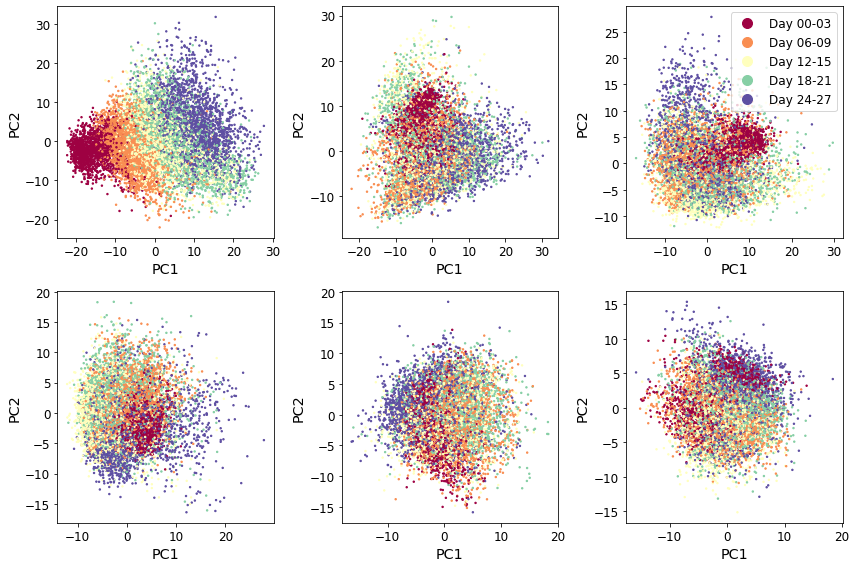

In [ ]:
# Create a figure (the background) and a set of axes (the things we plot on)
fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    # only plot a legend on one axis
    legend = True if i == 2 else False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['sample_labels'],
                        cmap='Spectral', ax=ax,
                        label_prefix="PC", legend=legend)
fig.tight_layout()

#### Plotting expression of a gene on the first two PCs

Now let's plot expression of some genes!


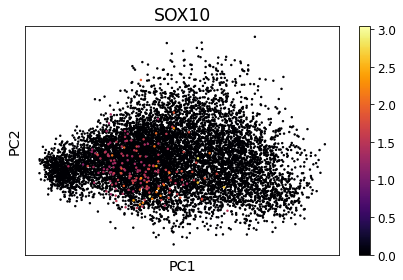

In [ ]:
gene = 'SOX10'

expression = scprep.select.select_cols(data, starts_with=gene)

# we will sort cells by maximum expression so we can see where the gene is expressed
sort_index = expression.sort_values().index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

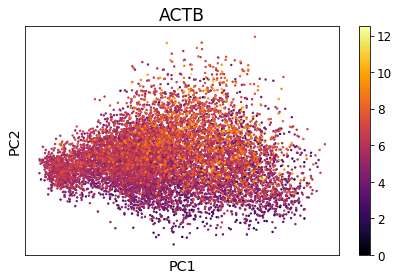

In [ ]:
gene = 'ACTB'

# ================
# Sort cells by maximum expression of ACTB and plot the result on PCA
expression = scprep.select.select_cols(data, starts_with=gene)

sort_index = expression.sort_values().index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                      title=gene, ticks=None, label_prefix='PC')
# ===============

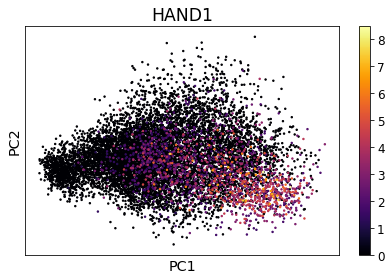

In [ ]:
gene = 'HAND1'

# ================
# Sort cells by maximum expression of HAND1 and plot the result on PCA
expression = scprep.select.select_cols(data, starts_with=gene)

sort_index = expression.sort_values().index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                      title=gene, ticks=None, label_prefix='PC')
# ===============

### Discussion

1. What do you notice? What does the first principle component track with? What about the second? What do you think the higher PCs represent? What does that mean?
- PC1: tracks with sample time. PC2: expands as sample time increases, indicating some kind of cellular heterogeneity marker

2. Why did we plot gene expression on the first two PCs?
- first two PCs represent the highest level structure of the data, so gene expression plotted on this gives us a broad undertanding of what's happening in the data. The genes allows us to characterize each part of the manifold.

3. Look up the function of these genes. What do you notice about where these genes are expressed? What does it mean when a gene is expressed everywhere vs. in one region?
- everywhere: likely some kind of housekeeping gene(indeed, Beta-actin is a part of the cell cytoskeleton and is expressed in all human cells). one region: likely to be cell-type specific, like HAND1 which is a heart/neural chest marker

## 3. t-SNE

#### How to use t-SNE effectively

Unlike PCA, t-SNE has *hyperparameters* these are user-specified options that determine the output of t-SNE. Having hyperparameters isn't bad, but it is essential to understand what the hyperparameters are, what the effect of hyperpameter choices have on output, and how to select the best set of hyperparameters for a given research objective.

In 2016, a group from Google Brain published great essay in Distill about ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/). In the article, they provide an interactive tool to explore the effect of various hyperparameters of t-SNE on various datasets.

There are two main hyperparameters for t-SNE: **perplexity** and **learning rate** (sometimes called epsilon). Perplexity determines the "neighborhood size". Larger values of perplexity increase the number of points within the neighborhood. The reccomended range of t-SNE perplexity is roughly 5-50. Learning rate affects how quickly the algorithm "stablilizes". You probably don't need to change this, but should understand what it is.

#### Running t-SNE on the embryoid body data

tSNE is implemented in `scikit-learn`. t-SNE is a manifold learning algorithm and you can find the t-SNE operator at [`sklearn.manifold.TNSE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

We create a t-SNE operator and run it on data just like the PCA operator

```python
from sklearn.manifold import TSNE
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)
```

### Excercise

In your groups, run TSNE on the EB dataset. Each person should pick a different perplexity. Note, in the following code block, we're using the first 20 PC components to speed up the run time (it should take 3-5 minutes to run). You can try changing the number of PCs and seeing how this affects output after the workshop. Think about why changing the number of PCs affects output.

### Discussion

1. What are the differences you see?
- with more PCs, the dataset effectively has retained more components of the data. As we increase the number of PCs, the t-SNE pplot shows more and more separation between group of cells

2. Try running t-SNE with the same parameters twice. What happens? Why?
- cluster placement moves around a lot. This is because t-SNE is randomly initialized each time, and global distances aren't considered in the algo, so the placement of clusters relative to one another doesn't matter at all

In [ ]:
from sklearn.manifold import TSNE

import tasklogger
with tasklogger.log_task('tSNE on {} cells'.format(data_pca.shape[0])):

    # Fitting tSNE. Change the perplexity here.
    tsne_op = TSNE(n_components=2, perplexity=30)
    data_tsne = tsne_op.fit_transform(data_pca.iloc[:,:20])

    # Put output into a dataframe
    data_tsne = pd.DataFrame(data_tsne, index=data.index)

Calculating tSNE on 9750 cells...
Calculated tSNE on 9750 cells in 85.62 seconds.


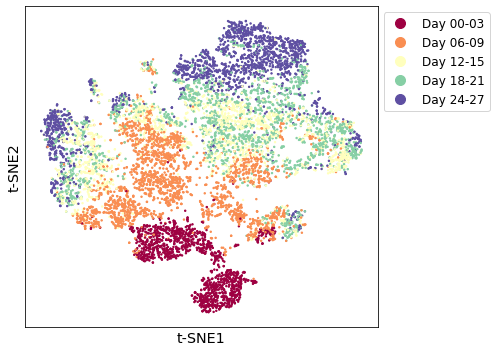

In [ ]:
scprep.plot.scatter2d(data_tsne, c=metadata['sample_labels'], cmap='Spectral', 
                      ticks=False, label_prefix='t-SNE', title='20 PCs',
                      legend_anchor=(1,1), figsize=(7,5))

In [ ]:
with tasklogger.log_task('tSNE on {} cells'.format(data_pca.shape[0])):

    # Fitting tSNE. Change the perplexity here.
    tsne_op = TSNE(n_components=2, perplexity=30)
    data_tsne = tsne_op.fit_transform(data_pca.iloc[:,:200])

    # Put output into a dataframe
    data_tsne = pd.DataFrame(data_tsne, index=data.index)

scprep.plot.scatter2d(data_tsne, c=metadata['sample_labels'], cmap='Spectral', 
                      ticks=False, label_prefix='t-SNE', title="200 PCs",
                      legend_anchor=(1,1), figsize=(7,5))

In [ ]:
with tasklogger.log_task('tSNE on {} cells'.format(data_pca.shape[0])):

    # Fitting tSNE. Change the perplexity here.
    tsne_op = TSNE(n_components=2, perplexity=30)
    data_tsne = tsne_op.fit_transform(data_pca.iloc[:,:5])

    # Put output into a dataframe
    data_tsne = pd.DataFrame(data_tsne, index=data.index)

scprep.plot.scatter2d(data_tsne, c=metadata['sample_labels'], cmap='Spectral', 
                      ticks=False, label_prefix='t-SNE', title="5 PCs",
                      legend_anchor=(1,1), figsize=(7,5))

#### Let's look at some marker genes!

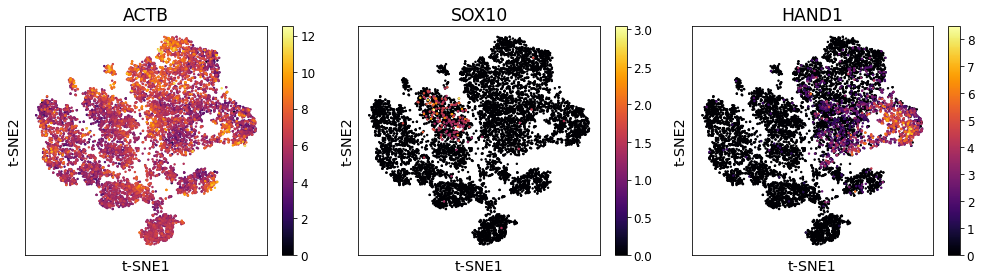

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']

for gene, ax in zip(genes_for_plotting, axes):
    expression = scprep.select.select_cols(data, exact_word=gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_tsne.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=gene, ticks=None, label_prefix='t-SNE', ax=ax)
    
fig.tight_layout()

### Discussion

Now, take some time in your groups to think of some pros and cons of using tSNE. What recommendations would you give to a new user who wants to know which parameters to try?

Pros: show good separation between cell types

cons: slow to run, global position of clusters is meaningless

recommendations: run multiple times to account for random initialization. try different values of perplexity (between 5 & 100) and diff number of PCs (btw 20 and 200)

## 3.3. Embedding Data Using UMAP

The syntax for UMAP is identical to t-SNE: `umap.UMAP().fit_transform`. UMAP is relatively fast, so you won't need to use the subsampled data.

UMAP's `n_neighbors` parameter describes the size of the neighborhood around each point. The `min_dist` parameter describes how tightly points can be packed together. The authors recommend values between 2 and 200 for `n_neighbors`, and between 0 and 0.99 for `min_dist`. Try a range of different values in and outside of these ranges and discuss the results with your group.

If you have some extra time, play around with the `min_dist` and `n_neighbors` parameters.

In [ ]:
import umap
data_umap = umap.UMAP().fit_transform(data_pca.iloc[:,:50])

In [ ]:
data_umap = pd.DataFrame(data_umap, index = data.index)

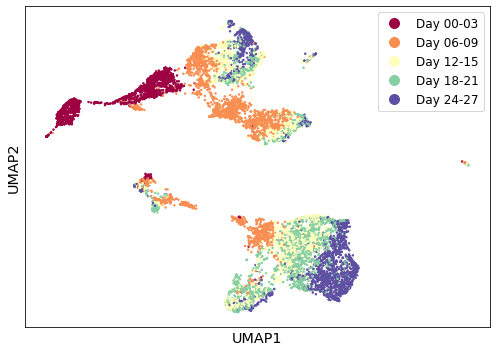

In [ ]:
# ================
# As you did with t-SNE, plot the UMAP coordinates
# colored by time point
scprep.plot.scatter2d(data_umap, c=metadata['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix='UMAP',
                      legend_anchor=(1, 1), figsize=(7, 5))
# ================

#### Let's look at some marker genes!

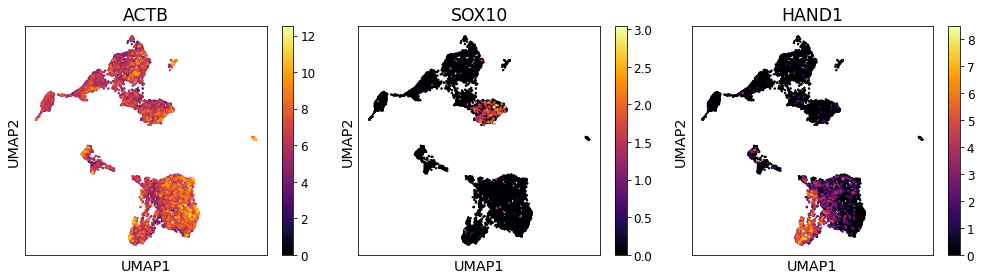

In [ ]:
genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']
# ================
# As you did with t-SNE, plot three subplots of the UMAP coordinates
# coloring by ACTB, SOX10 and HAND1
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes = axes.flatten()

for gene, ax in zip(genes_for_plotting, axes.flatten()):
    expression = scprep.select.select_cols(data, exact_word=gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_umap.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                          title=gene, ticks=None, label_prefix='UMAP', ax=ax)
# ================

fig.tight_layout()

### Discussion

1. What are the similarities and differences between UMAP and t-SNE? 

similarities: form coherent clusters of the data + have some randomness in their output

difference: UMAP more stable, seems to retain some global structure + tends to plot points more densely with more white space between clusters

2. Do you notice any parameter choices that seem to have similar effects between the algorithms?

`knn` (UMAP) and `perplexity` (t-SNE) are almost equivalent in their behavior

## 3.4. Embedding Data Using PHATE

#### How does PHATE work?

PHATE is a dimensionaltiy reduction developed by the Krishnaswamy lab for visualizing high-dimensional data. We use PHATE for *every* dataset the comes through the lab: scRNA-seq, CyTOF, gut microbiome profiles, simulated data, etc. PHATE was designed to handle noisy, non-linear relationships between data points. PHATE produces a low-dimensional representation that preserves both local and global structure in a dataset so that you can make generate hypotheses from the plot about the relationships between cells present in a dataset. Although PHATE has utility for analysis of many data modalities, we will focus on the application of PHATE for scRNA-seq analysis.

PHATE is inspired by diffusion maps [(Coifman et al. 2008.)](https://doi.org/10.1016/j.acha.2006.04.006), but include several key innovations that make it possible to generate a two or three dimensional visualization that preserves continuous relationships between cells where they exist. For a full explanation of the PHATE algorithm, please consult [the PHATE manuscript](https://doi.org/10.1101/120378).

#### Using the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

Like tSNE, PHATE has it's own set of hyperparameters. Changing the parameters will greatly change the output of the algorithm. We reccomend starting with the defaults, then change `knn` and `decay` according the reccomendations below. Generally, we won't select `t` ourselves, but if you're tuning hyperparameters, it's best to fix `t`.

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `k` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `a` increases connectivity on the graph, increasing `a` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE. Running this should take ~1-3 minutes.

In [ ]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data_pca.iloc[:,:50])
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 9750 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 8.23 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 8.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.60 seconds.
    Calculating KMeans...
    Calculated KMeans in 42.04 seconds.
  Calculated landmark operator in 45.12 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 6.52 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 4.09 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.19 seconds.
Calculated PHATE in 73.32 seconds.


And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

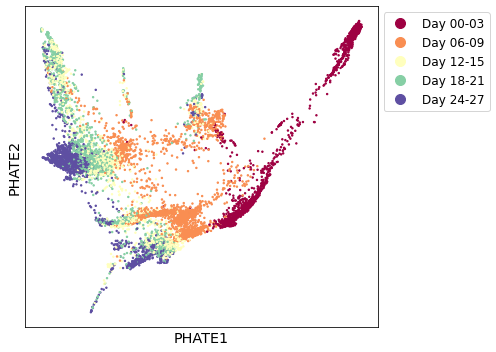

In [ ]:
# ================
# As you did with t-SNE and UMAP, plot the PHATE coordinates
# colored by time point
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix='PHATE',
                      legend_anchor=(1, 1), figsize=(7, 5))
# ================

#### Gene visualization

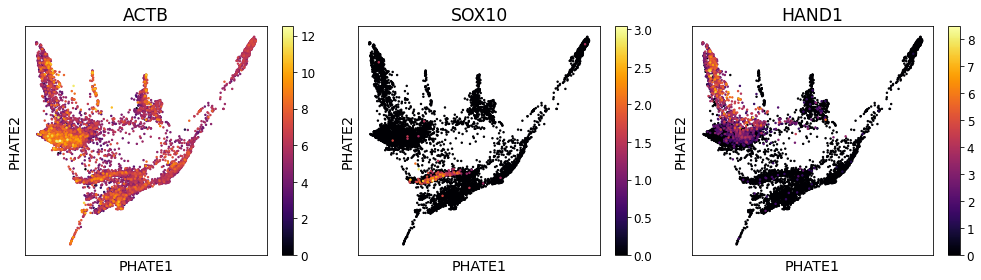

In [ ]:
# ================
# As you did with t-SNE and UMAP, plot three subplots of the PHATE coordinates
# coloring by ACTB, SOX10 and HAND1
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()

for gene, ax in zip(genes_for_plotting, axes.flatten()):
    expression = scprep.select.select_cols(data, exact_word=gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=gene, ticks=None, label_prefix='PHATE', ax=ax)

fig.tight_layout()
# ================
# ================

### Discussion

In groups, discuss the following questions:
1. In a dataset with trajectories, how well does each method perform?

PHATE is the only one of these 3 methods which reliably retains trajectory-like structure. t-SNE and UMAP tend to break them into clusters, though UMAP less so than t-SNE

2. Now that you've seen all the methods, how might you include them in a workflow?
- makes sense to do both PHATE and UMAP alongside one another. If you can identify similar structures in both, the structures are likely real (since the methods are so different!)

3. What are the advantages of each method?
- UMAP & t-SNE do well to show cluster structures. PHATE does well to show continuous structures
- UMAP & t-SNE show the no of points in each cluster/region, while PHATE shows much more clearly the heterogeneity of regions but doesn't obviously show the number of points
- UMAP & PHATE are fast

4. If you didn't know if your data contained clusters or trajectories, what would you do?
- run PHATE and UMAP together